In [48]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../src")
from utils import BaseGeometryTransformer

In [49]:
voxl_imu0 = pd.read_csv("../../data/UAV/log0001/run/mpa/imu0/data.csv")
voxl_imu1 = pd.read_csv("../../data/UAV/log0001/run/mpa/imu1/data.csv")
px4_imu0 = pd.read_csv("../../data/UAV/log0001/px4/imu_combined/log0001_px4_imu0_combined.csv")
px4_imu1 = pd.read_csv("../../data/UAV/log0001/px4/imu_combined/log0001_px4_imu1_combined.csv")

actuator_motor = pd.read_csv("../../data/UAV/log0001/px4/09_00_22_actuator_motors_0.csv")
actuator_output = pd.read_csv("../../data/UAV/log0001/px4/09_00_22_actuator_outputs_1.csv")

gps_raw = pd.read_csv("../../data/UAV/log0001/px4/09_00_22_sensor_gps_0.csv")

In [50]:
acc_col = ['AX(m/s2)', 'AY(m/s2)', 'AZ(m/s2)']
gyr_col = ['GX(rad/s)', 'GY(rad/s)', 'GZ(rad/s)']
gps_lla = ['lon', 'lat', 'alt']
gps_ned = ['north', 'east', 'down']
control_col = ['control[0]', 'control[1]', 'control[2]', 'control[3]']

In [51]:
voxl_imu0['timestamp'] = voxl_imu0['timestamp(ns)'] / 1e3
voxl_imu1['timestamp'] = voxl_imu1['timestamp(ns)'] / 1e3

voxl_imu0 = voxl_imu0[voxl_imu0.columns[2:]]
voxl_imu1 = voxl_imu1[voxl_imu1.columns[2:]]
px4_imu0 = px4_imu0[px4_imu0.columns[1:]]
px4_imu1 = px4_imu1[px4_imu1.columns[1:]]

gps_raw = gps_raw[['timestamp', 'lon', 'lat', 'alt']]

actuator_motor = actuator_motor[['timestamp', 'control[0]', 'control[1]', 'control[2]', 'control[3]']]
actuator_output = actuator_output[['timestamp', 'output[0]', 'output[1]', 'output[2]', 'output[3]']]


px4_imu0_timestamp = (px4_imu0['timestamp'].iloc[0], px4_imu0['timestamp'].iloc[-1])

timestamp_filter = voxl_imu0['timestamp'] > px4_imu0_timestamp[0]
timestamp_filter &= voxl_imu0['timestamp'] <= px4_imu0_timestamp[1]
voxl_imu0 = voxl_imu0.loc[timestamp_filter]

timestamp_filter = voxl_imu1['timestamp'] > px4_imu0_timestamp[0]
timestamp_filter &= voxl_imu1['timestamp'] <= px4_imu0_timestamp[1]
voxl_imu1 = voxl_imu1.loc[timestamp_filter]

timestamp_filter = px4_imu1['timestamp'] > px4_imu0_timestamp[0]
timestamp_filter &= px4_imu1['timestamp'] <= px4_imu0_timestamp[1]
px4_imu1 = px4_imu1.loc[timestamp_filter]


geo_transformer = BaseGeometryTransformer()

In [52]:
def decimal_place_shift(values: np.ndarray) -> float:
    return np.array([float(value / 10**(len(str(value)) - 2)) for value in values])

origin = decimal_place_shift(gps_raw[gps_lla].iloc[0].values)
converted = np.array([decimal_place_shift(value) for value in gps_raw[gps_lla].values.T])
gps_ned_values = geo_transformer.lla_to_ned(converted, origin).T
gps = pd.concat([
    gps_raw,
    pd.DataFrame(gps_ned_values, columns=gps_ned)
],  axis=1)

In [53]:
VOXL_ESC_RPM_MAX = 15000
M500_WEIGHT = 1.075

# Trajectory

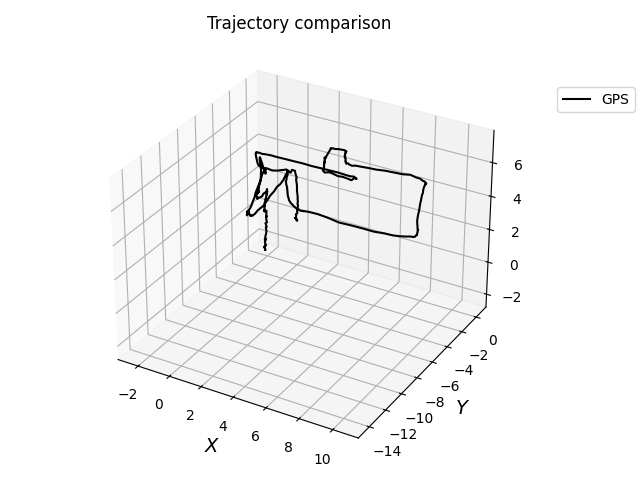

In [54]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectory comparison")

x, y, z = gps[gps_ned].values.T

ax.plot(x, y, -z, label="GPS", color="black")

ax.legend(loc='best', bbox_to_anchor=(1.1, 0., 0.2, 0.9))

ax.set_xlabel('$X$', fontsize=14)
ax.set_ylabel('$Y$', fontsize=14)
# ax.set_zlabel('$Z$', fontsize=14)
fig.tight_layout()

In [30]:
plt.close()

# Motor output

To calculate the rotor angular velocity (in radians per second) or RPM (revolutions per minute) of a quadcopter based on the `actuator_motors` values from the PX4 logs, you need to follow these steps:

### 1. **Understanding the Motor Control Output Values**:
   - **Control Values** (`control` array): The values in this array range from `-1` to `1`, where:
     - `1` represents maximum positive thrust.
     - `-1` represents maximum negative thrust (if reversible motors are supported).
     - `0` typically represents no thrust.
     - Values in between represent proportional thrust between the minimum and maximum.

### 2. **Relating Control Values to Rotor RPM**:
   - The control values typically correspond to a percentage of the maximum RPM or angular velocity that the motor can achieve. For example:
     - A control value of `1` might correspond to the maximum RPM of the motor.
     - A control value of `0.5` would correspond to 50% of the maximum RPM.
     - A control value of `-1` (for reversible motors) might correspond to maximum RPM in the reverse direction.

   To find the actual RPM, you would use the following relationship:

   \[
   \text{RPM} = \text{max\_RPM} \times \text{control\_value}
   \]

   Where:
   - `max_RPM` is the maximum RPM the motor can achieve.
   - `control_value` is the value from the `control` array.

### 3. **Calculating Angular Velocity**:
   - Angular velocity (\(\omega\)) in radians per second can be related to RPM by the following formula:

 $omega = \text{RPM} \times \frac{2\pi}{60}$


   Substituting the RPM formula:

  
 $omega = \text{max\_RPM} \times \text{control\_value} \times \frac{2\pi}{60}$


### 4. **Considerations**:
   - **Motor Characteristics**: You need to know the maximum RPM (`max_RPM`) of the motors used on your quadcopter. This information is typically provided by the motor manufacturer.
   - **Motor Calibration**: Ensure that the motor output is correctly calibrated so that the control value of `1` indeed corresponds to the maximum RPM.
   - **Reversible Motors**: If your motors are reversible, the calculation applies similarly, but negative control values would indicate reverse rotation.

### 5. **Practical Example**:
   Suppose the maximum RPM of your motor is `10,000 RPM`, and you have a control value of `0.5` in the `actuator_motors` log:

  $text{RPM} = 10,000 \times 0.5 = 5,000 \, \text{RPM}$

   Then, the angular velocity would be:

   $omega = 5000 \times \frac{2\pi}{60} \approx 523.6 \, \text{radians/second}$

### Conclusion:
To calculate the rotor angular velocity or RPM from `actuator_motors` control values, you need the maximum RPM of the motors and apply the above formulas. The control values directly scale the maximum RPM or angular velocity, allowing you to convert them into meaningful physical quantities like RPM or radians per second.


### VOXL_ESC_RPM_MAX	15000

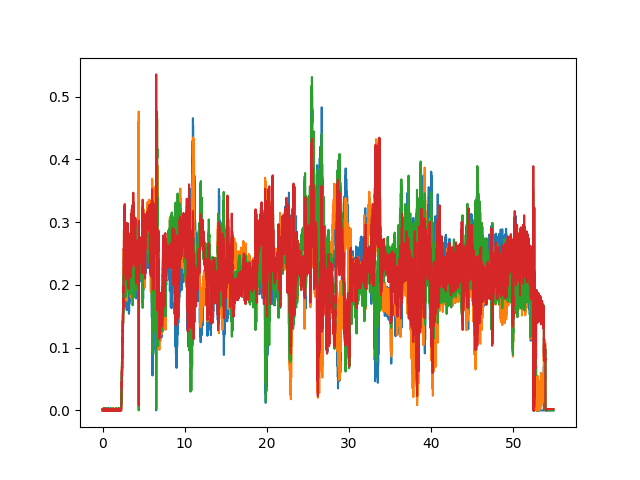

In [33]:
motor_ts = actuator_motor['timestamp'].diff() / 1e6
motor_ts[0] = 0.0
plt.plot(np.cumsum(motor_ts), actuator_motor['control[0]'].values)
plt.plot(np.cumsum(motor_ts), actuator_motor['control[1]'].values)
plt.plot(np.cumsum(motor_ts), actuator_motor['control[2]'].values)
plt.plot(np.cumsum(motor_ts), actuator_motor['control[3]'].values)

In [35]:
actuator_motor_freq = actuator_motor.shape[0] / motor_ts.sum()
print(f"Actuator motor output frequency: {round(actuator_motor_freq, 2)}Hz")

Actuator motor output frequency: 284.9Hz


In [38]:
actuator_motor[control_col]

,control[0],control[1],control[2],control[3]
0,2.136615e-03,5.258889e-11,2.136615e-03,0.000000
1,2.136614e-03,7.465131e-11,1.605764e-03,0.000531
2,1.395877e-03,7.908957e-11,1.097319e-03,0.001780
3,6.566017e-11,2.123350e-03,6.413911e-04,0.001508
4,3.768626e-11,2.136614e-03,0.000000e+00,0.002137
...,...,...,...,...
15626,1.595759e-10,2.168072e-03,4.951881e-13,0.002168
15627,4.849039e-10,2.168072e-03,2.585254e-12,0.002168
15628,1.094705e-10,2.168072e-03,6.944820e-12,0.002168
15629,1.195423e-10,2.168072e-03,5.109749e-13,0.002168


## Motor configuration of Modal AI M500
<img src="https://docs.modalai.com/images/m500/voxl-m500-motor-configuration.png"/>

In [45]:
actuator_motor['control_12'] = actuator_motor['control[0]'] * actuator_motor['control[1]']
actuator_motor['control_23'] = actuator_motor['control[1]'] * actuator_motor['control[2]']
actuator_motor['control_34'] = actuator_motor['control[2]'] * actuator_motor['control[3]']
actuator_motor['control_41'] = actuator_motor['control[3]'] * actuator_motor['control[0]']
actuator_motor['control_13'] = actuator_motor['control[0]'] * actuator_motor['control[2]']
actuator_motor['control_24'] = actuator_motor['control[1]'] * actuator_motor['control[3]']

In [47]:
actuator_motor['control_13'] - actuator_motor['control_24']

0        0.000005
1        0.000003
2        0.000002
3       -0.000003
4       -0.000005
           ...   
15626   -0.000005
15627   -0.000005
15628   -0.000005
15629   -0.000005
15630   -0.000005
Length: 15631, dtype: float64

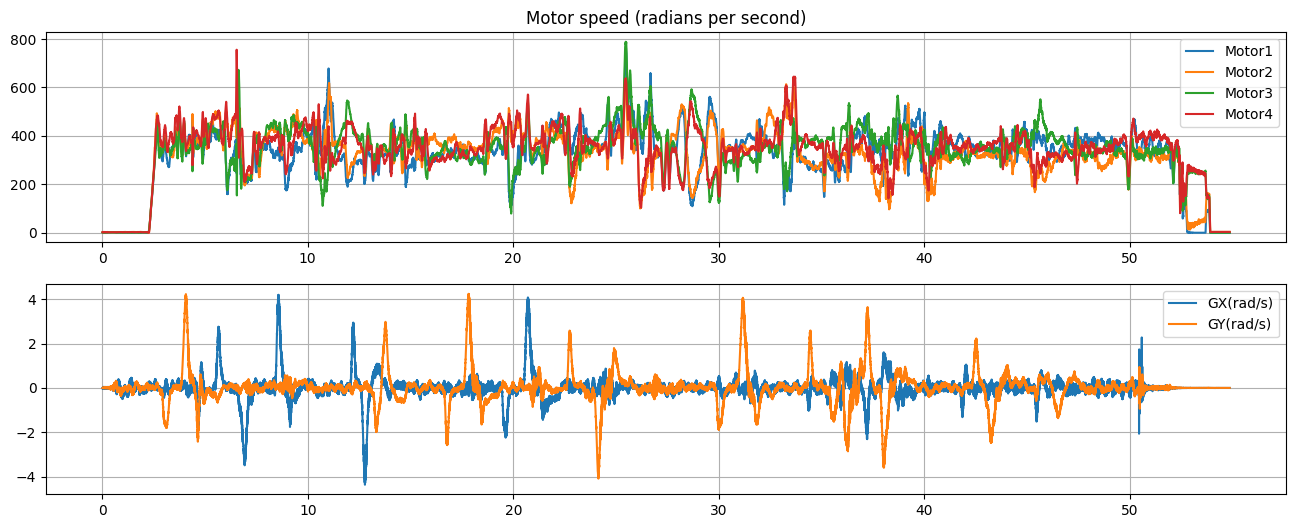

In [288]:
%matplotlib inline
rotor_velocity = lambda x : VOXL_ESC_RPM_MAX * x * 2*np.pi/60

window = 10
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

axs[0].plot(
    np.cumsum(motor_ts), 
    rotor_velocity(actuator_motor['control[0]'].rolling(window=window).mean()),
    label="Motor1"
)
axs[0].plot(
    np.cumsum(motor_ts), 
    rotor_velocity(actuator_motor['control[1]'].rolling(window=window).mean()),
    label="Motor2"
)
axs[0].plot(
    np.cumsum(motor_ts), 
    rotor_velocity(actuator_motor['control[2]'].rolling(window=window).mean()),
    label="Motor3"
)
axs[0].plot(
    np.cumsum(motor_ts), 
    rotor_velocity(actuator_motor['control[3]'].rolling(window=window).mean()),
    label="Motor4"
)

axs[0].title.set_text("Motor speed (radians per second)")
axs[0].legend()
axs[0].grid()

voxl_imu0_ts = voxl_imu0['timestamp'].diff() / 1e6
voxl_imu0_ts.iloc[0] = 0.0
voxl_imu0_ts = np.cumsum(voxl_imu0_ts)
axs[1].plot(voxl_imu0_ts, voxl_imu0['GX(rad/s)'].values, label="GX(rad/s)")
axs[1].plot(voxl_imu0_ts, voxl_imu0['GY(rad/s)'].values, label="GY(rad/s)")
axs[1].legend()
axs[1].grid()


## Motor configuration of Modal AI M500
<img src="https://docs.modalai.com/images/m500/voxl-m500-motor-configuration.png"/>

In [69]:
window = 1
r1_w = rotor_velocity(actuator_motor['control[0]'].rolling(window=window).mean().values)
r2_w = rotor_velocity(actuator_motor['control[1]'].rolling(window=window).mean().values)
r3_w = rotor_velocity(actuator_motor['control[2]'].rolling(window=window).mean().values)
r4_w = rotor_velocity(actuator_motor['control[3]'].rolling(window=window).mean().values)

w = np.vstack([
    r1_w * 180/np.pi,
    r2_w,
    r3_w,
    r4_w
])

print(w.shape)

(4, 15631)


### In quadcopter X configuration, the Thrust and torque can be calculated by:
$\begin{bmatrix} 
T \\ \tau_{x} \\ \tau_{y} \\ \tau_{z}
\end{bmatrix}$ =
$\begin{bmatrix} 
b & b & b & b \\ -db & db & db & -db \\ db & -db & db & -db \\ k & k & -k & -k
\end{bmatrix}$
$\begin{bmatrix} 
w^{2}_{1} \\ w^{2}_{2} \\ w^{2}_{3} \\ w^{2}_{4}
\end{bmatrix}$


where, b > 0 is a lift constant that depends on the air density and characteristics of the brade. d is the distance from the center of mass to the rotors generating thr thrust. k defines the aerodynamic drag that is oppose to the torque applied to the each rotor.

In [70]:
b = np.array([0.1, 0.1, 0.1, 0.1])
d = np.array([0.25, 0.25, 0.25, 0.25])
k = np.array([1., 1., 1., 1.])

M = np.array([
    [1., 1., 1., 1.],
    [-1., 1., 1., -1.],
    [1., -1., 1., -1.],
    [1., 1., -1., -1.]
])
M[0] *= b
M[1] *= b*d
M[2] *= b*d
M[3] *= k
M

array([[ 0.1  ,  0.1  ,  0.1  ,  0.1  ],
       [-0.025,  0.025,  0.025, -0.025],
       [ 0.025, -0.025,  0.025, -0.025],
       [ 1.   ,  1.   , -1.   , -1.   ]])

In [71]:
T = M @ w

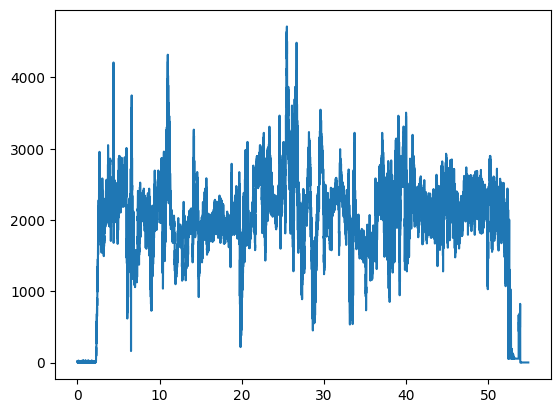

In [12]:
plt.plot(np.cumsum(motor_ts), T[0, :])

In [13]:
a = T[0, :] / M500_WEIGHT

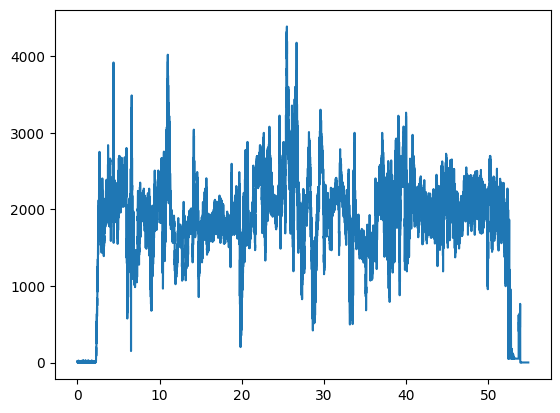

In [14]:
plt.plot(np.cumsum(motor_ts), a)